# Quantile Regresssion

# Theoretic Foundation

The goal of Quantile Regression is to extend a standard regression model to also predict conditional quantiles that approximate the true quantiles of the data at hand. It does not make assumptions about the distribution of errors as is usually common. It is a more commonly used method in Econometrics and Time-series forecasting.

In the following we will describe univariate quantile regression. Any chosen conditional quantile $α \in [0,1]$ can be defined as $q_\alpha(x):=\text{inf}\{y \in \mathbb{R}: F(y \vert X = x ) \geq \alpha\}$ where $F(y \vert X = x)=P(Y\leq y\vert X = x)$ is a strictly monotonic increasing cumulative density function.


Given a neural network $f$ parameterized by $\theta$, we would configure the number of outputs to be equivalent to the number of quantiles we want to predict. This means that, if we want to predict $n$ quantiles $[q_1, ... q_n]$, $f_{\theta}(x) = (\hat{y}_1, ...,\hat{y}_n)$. The model is subsequently trained by minimizing the pinball loss function ([Koenker and Basset 1978](https://www.jstor.org/stable/1913643)).


The Pinball Loss, or also called Quantiles Loss, for a given quantile $q_i \in [q_1, ... q_n]$ is then defined as follows:
 $\mathcal{L}(y_i, \hat{y}_i, q_i)=\max(q_i (y_i - \hat{y}_i), (1-q_i)(y_i-\hat{y}_i))$

where $y_i$ is the true target and $\hat{y}_i$ is the model output. While one does not actually know the true quanitles, the loss yields an approximation to these
them. To see this, consider setting $q=\frac{1}{2}$, then this loss is equal to the Mean Absolute Error, which is minimized by predicting the median. For an explanation of the pinball loss function you can checkout this [blog post](https://towardsdatascience.com/probabilistic-forecasts-pinball-loss-function-baf86a5a14d0). 

During inference, the model will output an estimate for your chosen quantiles and these can be used as an indication of aleatoric uncertainty.


# Imports

In [1]:
import os
import sys

# required to make the path visible to import the tools
# this will change in public notebooks to be "pip install uq-regression-box"
nb_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
nb_dir

import tempfile
import torch
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from uq_method_box.datamodules import ToyHeteroscedasticDatamodule
from uq_method_box.models import MLP
from uq_method_box.viz_utils import (
    plot_predictions,
    plot_calibration_uq_toolbox,
    plot_training_metrics,
    plot_toy_data,
)
from uq_method_box.uq_methods import QuantileRegressionModel
import torch.nn as nn
from lightning import Trainer
from lightning.pytorch import seed_everything
from lightning.pytorch.loggers import CSVLogger

plt.rcParams["figure.figsize"] = [14, 5]

In [2]:
seed_everything(0)  # seed everything for reproducibility

Global seed set to 0


0

We define a temporary directory to look at some training metrics and results.

In [3]:
my_temp_dir = tempfile.mkdtemp()

# Datamodule

To demonstrate the method, we will make use of a Toy Regression Example that is defined as a [Lightning Datamodule](https://lightning.ai/docs/pytorch/stable/data/datamodule.html). While this might seem like overkill for a small toy problem, we think it is more helpful how the individual pieces of the library fit together so you can train models on more complex tasks.

In [4]:
dm = ToyHeteroscedasticDatamodule()

X_train, y_train, train_loader, X_test, y_test, test_loader = (
    dm.X_train,
    dm.y_train,
    dm.train_dataloader(),
    dm.X_test,
    dm.y_test,
    dm.test_dataloader(),
)

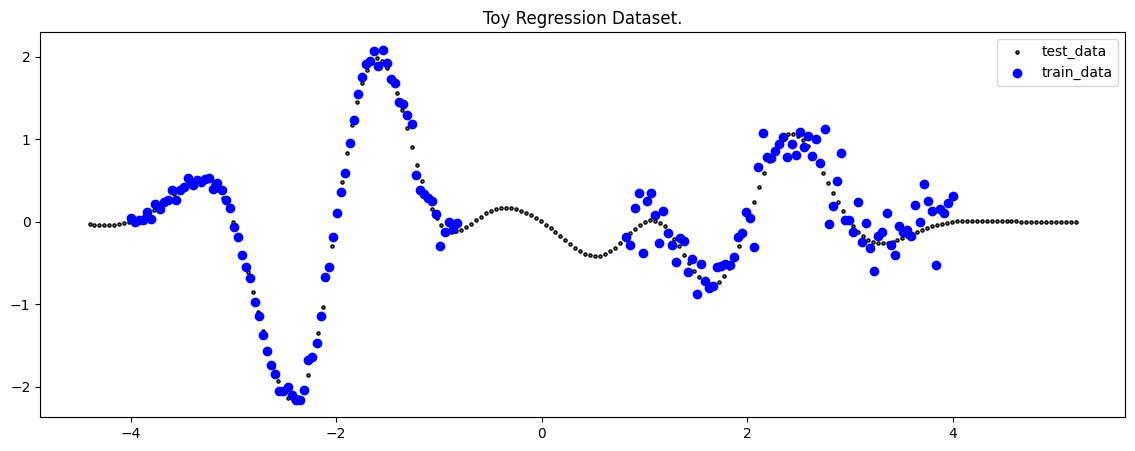

In [5]:
plot_toy_data(X_train, y_train, X_test, y_test)

# Model

For our Toy Regression problem, we will use a simple Multi-layer Perceptron (MLP) that you can configure to your needs. For the documentation of the MLP see [here](https://torchgeo.readthedocs.io/en/stable/api/models.html#MLP). For quantile regression we need a network output for each of the quantiles that we want to predict.

In [6]:
quantiles = [0.1, 0.5, 0.9]
network = MLP(
    n_inputs=1,
    n_hidden=[50, 50, 50],
    n_outputs=len(quantiles),
    activation_fn=nn.Tanh(),
)
network

MLP(
  (model): Sequential(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Tanh()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): Tanh()
    (8): Dropout(p=0.0, inplace=False)
    (9): Linear(in_features=50, out_features=3, bias=True)
  )
)

With an underlying neural network, we can now use our desired UQ-Method as a sort of wrapper. All UQ-Methods are implemented as [LightningModule](https://lightning.ai/docs/pytorch/stable/common/lightning_module.html) that allow us to concisely organize the code and remove as much boilerplate code as possible.

In [7]:
qr_model = QuantileRegressionModel(
    model=network,
    optimizer=partial(torch.optim.Adam, lr=4e-3),
    quantiles=quantiles,
    save_dir=my_temp_dir
)

# Trainer

Now that we have a LightningDataModule and a UQ-Method as a LightningModule, we can conduct training with a [Lightning Trainer](https://lightning.ai/docs/pytorch/stable/common/trainer.html). It has tons of options to make your life easier, so we encourage you to check the documentation.

In [8]:
logger = CSVLogger(my_temp_dir)
trainer = Trainer(
    max_epochs=250,  # number of epochs we want to train
    logger=logger,  # log training metrics for later evaluation
    log_every_n_steps=1,
    enable_checkpointing=False,
    enable_progress_bar=False,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training our model is now easy:

In [9]:
trainer.fit(qr_model, dm)


  | Name          | Type             | Params
---------------------------------------------------
0 | train_metrics | MetricCollection | 0     
1 | val_metrics   | MetricCollection | 0     
2 | test_metrics  | MetricCollection | 0     
3 | model         | MLP              | 5.4 K 
4 | loss_fn       | QuantileLoss     | 0     
---------------------------------------------------
5.4 K     Trainable params
0         Non-trainable params
5.4 K     Total params
0.021     Total estimated model params size (MB)
/home/nils/.virtualenvs/uqboxEnv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/nils/.virtualenvs/uqboxEnv/lib/python3.9/site-packages/lightning/pytorch/t

# Training Metrics

To get some insights into how the training went, we can use the utility function to plot the training loss and RMSE metric.

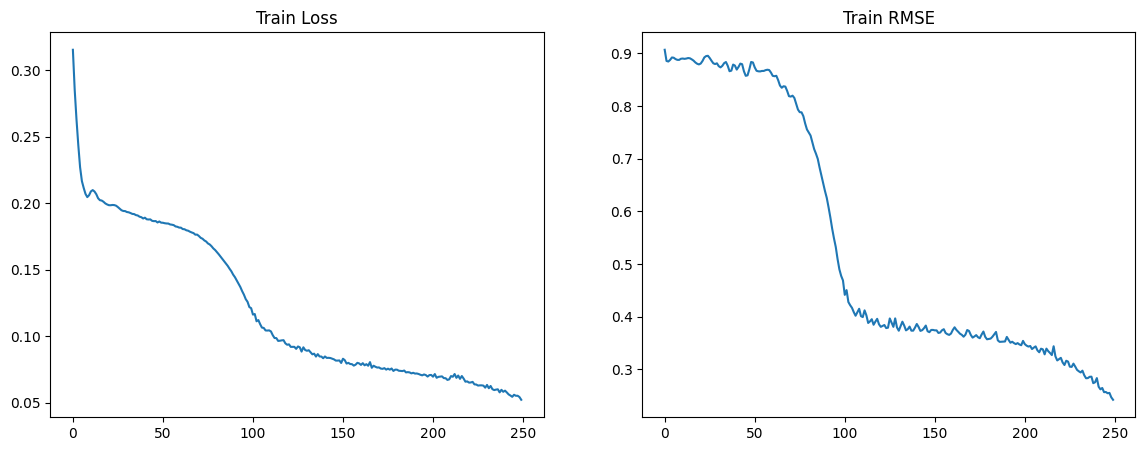

In [10]:
fig = plot_training_metrics(my_temp_dir)

# Prediction

For prediction we can either rely on the `trainer.test()` method or manually conduct a `predict_step()`. Using the trainer will save the predictions and some metrics to a CSV file, while the manual `predict_step()` with a single input tensor will generate a dictionary that holds the mean prediction as well as some other quantities of interest, for example the predicted standard deviation or quantile.

In [11]:
preds = qr_model.predict_step(X_test)

# Evaluate Predictions

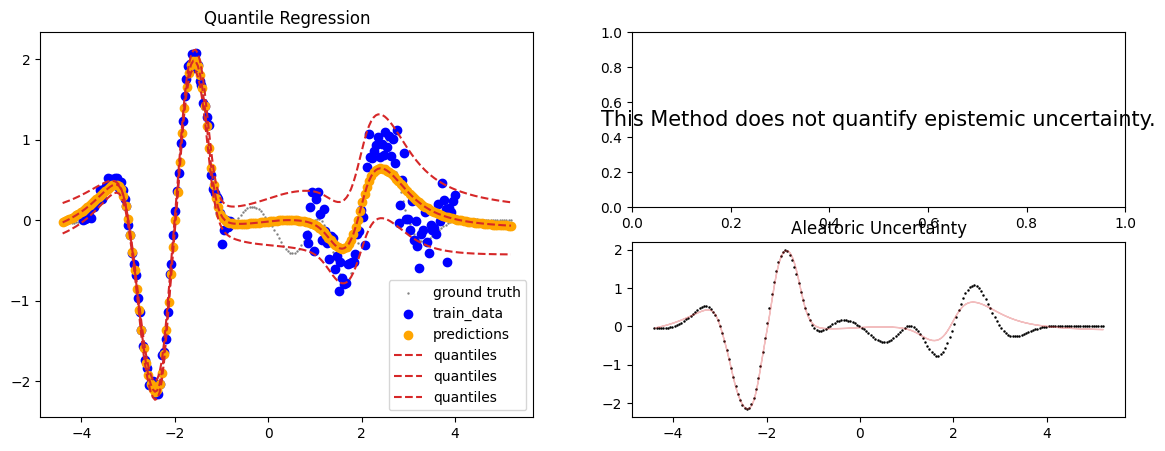

In [12]:
fig = plot_predictions(
    X_train,
    y_train,
    X_test,
    y_test,
    preds["mean"],
    pred_quantiles=np.stack([preds["lower_quant"], preds["mean"], preds["upper_quant"]], axis=-1),
    aleatoric=preds["aleatoric_uct"],
    title="Quantile Regression",
)

For some additional metrics relevant to UQ, we can use the great [uncertainty-toolbox](https://uncertainty-toolbox.github.io/) that gives us some insight into the calibration of our prediction. For a discussion of why this is important, see ...

<Figure size 1400x500 with 0 Axes>

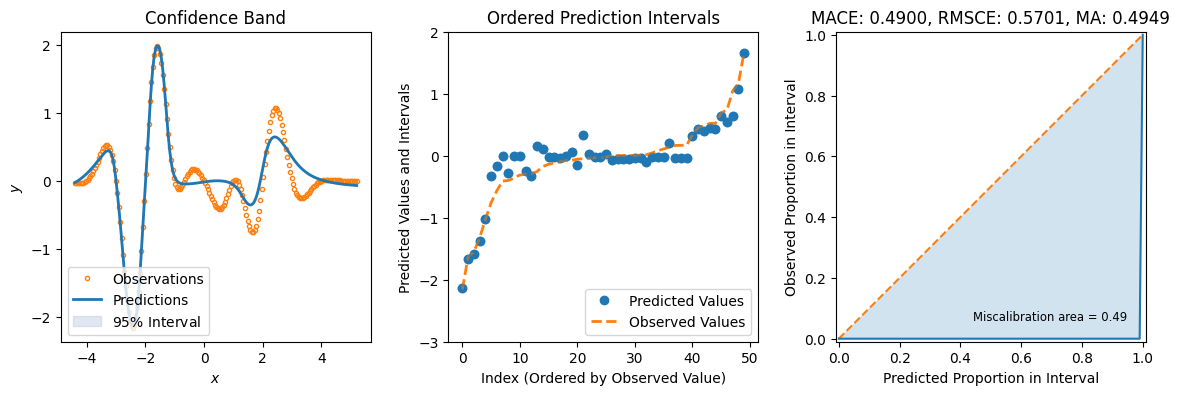

In [13]:
fig = plot_calibration_uq_toolbox(
    preds["mean"], preds["pred_uct"], y_test.cpu().numpy(), X_test.cpu().numpy()
)

# Additional Resources

Links to othere related literature that might be interesting.